In [53]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Node temporal features

In [54]:
def logistic_regression(X, y):
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000, n_jobs=-1))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

class FeatureSet(typing.NamedTuple):
  time: str
  nodepair: str
  network: int
    
def get_features(network_index: int,
                 time_strategy_label: typing.Optional[str],
                 nodepair_strategy_label: typing.Optional[str],
                 hypergraph: bool) -> np.ndarray:
  """Get all features for the provided network_index, 
  time_strategy_label and nodepair_strategy_label. When one of the later
  two is None, provide all available strategies.
  """
  aggregation_strategies = [
    'm0', 'm1', 'q0', 'q25', 'q50', 'q75', 'q100'] # Overwrite global variable!
  features = [
    np.load(f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy') 
    for heuristic in heuristics
  ]
  
  if time_strategy_label is None:
    time_strategy_labels = list(time_strategies) # RHS is global variable
  else:
    time_strategy_labels = [time_strategy_label]
  
  if nodepair_strategy_label is None:
    nodepair_strategy_labels = list(nodepair_strategies) # RHS is global variable
  else:
    nodepair_strategy_labels = [nodepair_strategy_label]
    
  for t_strategy_label in time_strategy_labels:
    for np_strategy_label in nodepair_strategy_labels:
      if hypergraph:
        for agg_strategy_label in aggregation_strategies:
          features.append(
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{t_strategy_label}_{np_strategy_label}_{agg_strategy_label}.npy'
            )
          )
      else:
        features.append(
          np.load(f'data/{network_index:02}/features/time_node/'
                  f'{t_strategy_label}_{np_strategy_label}.npy')
        )
  return np.stack(features, axis=1)
  
def get_all_features(
) -> dict[FeatureSet, typing.Union[np.ndarray, pd.DataFrame]]:
  feature_sets = dict()
  for network_index in network_indices:
    for t_label in list(time_strategies) + [None]:
      for np_label in list(nodepair_strategies) + [None]:
        feature_sets[
          FeatureSet(
            network=network_index, 
            time='combined' if t_label is None else t_label,
            nodepair='combined' if np_label is None else np_label)
        ] = get_features(network_index, t_label, np_label, 
                         hypergraph=network_index in hypergraph_indices)
  return feature_sets

In [55]:
featuresets = get_all_features()

In [56]:
auc_featuresets = [
  {
    'auc': logistic_regression(
      X=featureset, 
      y=np.load(f'data/{featureset_id.network:02}/targets_sampled.npy')),
    **featureset_id._asdict()
  }
  for featureset_id, featureset in tqdm(featuresets.items())
]

  0%|          | 0/520 [00:00<?, ?it/s]

In [57]:
df = pd.DataFrame(auc_featuresets)
df

,auc,time,nodepair,network
0,0.794680,lin,sum,1
1,0.700334,lin,diff,1
2,0.752408,lin,max,1
3,0.797260,lin,min,1
4,0.791877,lin,combined,1
...,...,...,...,...
515,0.838841,combined,sum,30
516,0.831199,combined,diff,30
517,0.834577,combined,max,30
518,0.839944,combined,min,30


In [62]:
auc_table = (
  df
  .groupby(['time', 'nodepair'])['auc']
  .mean()
  .unstack()
  .loc[['lin', 'sqrt', 'exp', 'combined'], 
       ['min', 'max', 'diff', 'sum', 'combined']]
)
auc_table

nodepair,min,max,diff,sum,combined
time,,,,,
lin,0.863109,0.859215,0.829742,0.869337,0.872672
sqrt,0.863207,0.858732,0.830204,0.867815,0.875233
exp,0.863838,0.859883,0.831540,0.868757,0.875288
combined,0.866478,0.862998,0.835628,0.874534,0.880043


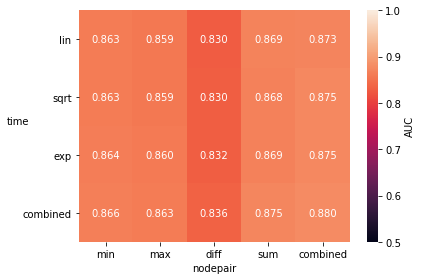

In [63]:
g = sns.heatmap(auc_table, annot=True, vmin=.5, vmax=1, fmt='.3f',
                cbar_kws=dict(label='AUC'))
g.set_yticklabels(g.get_yticklabels(), rotation = 0);
g.set_ylabel(g.get_ylabel(), rotation=0)
plt.tight_layout()
plt.savefig('figures/table-nodepair-strategies.pdf')